# Model Selection

In [132]:
import math
import pickle
from copy import deepcopy
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.dummy import DummyClassifier
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import confusion_matrix

                                      
%matplotlib inline

In [2]:
df = pd.read_csv('sample_data.csv')

In [7]:
sample_data = deepcopy(df)

# Train-Test split

Need to split the dataset into train and test, then use cross val to traing the classifier.

In [9]:
y = np.array(df.pop('star_rating'))

In [11]:
X = df.as_matrix()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,
                                                    random_state=1,stratify=y)

# Histogram of Star Ratings in Traing Set

In [246]:
c = pd.Series(y_train).value_counts().sort_index()


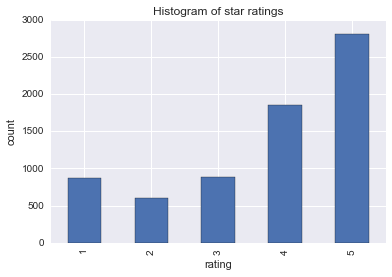

In [255]:
c.plot(kind='bar')
plt.ylabel('count')
plt.xlabel('rating')
plt.title('Histogram of star ratings')

# Baseline Model - highest frequency

In [14]:
dummy = DummyClassifier(strategy='most_frequent', random_state=1) 

In [15]:
dummy.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=1, strategy='most_frequent')

In [16]:
dummy.score(X_test,y_test)

0.40066666666666667

# Simple Naive Bayes Model

In [17]:
mnb = MultinomialNB(fit_prior=True).fit(X_train,y_train)

In [18]:
mnb.score(X_test,y_test)

0.54833333333333334

#### Visualize Predictions

In [19]:
preds = mnb.predict(X_test)

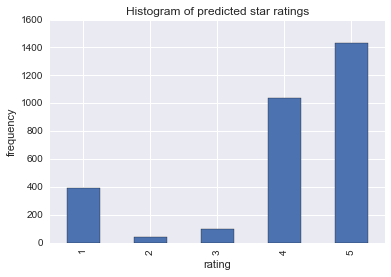

In [249]:
pd.Series(preds).value_counts().sort_index().plot(kind='bar')
plt.ylabel('frequency')
plt.xlabel('rating')
plt.title('Histogram of predicted star ratings')

# Inspecting Errors

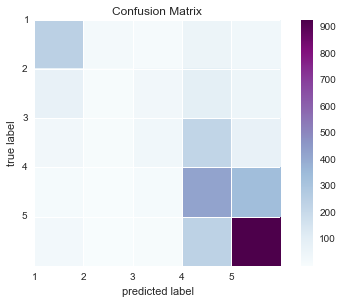

In [46]:
cm = confusion_matrix(y_test,preds,labels=[1,2,3,4,5])


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.colorbar()
plt.xticks(np.arange(-.5,4.5), np.arange(1,6))
plt.yticks(np.arange(-.5,4.5), np.arange(1,6))
plt.tight_layout()
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion Matrix')

The class imbalance problem is dramatically skewing the results. Need to address the class imbalance problem.

# Over Sampling

First we need to define some helper function to enable us to get the rate at which to sample the unbalanced classes. We want to grab them at a rate that is inversely proportional to their representation in sample. 

In [47]:
def class_freqs(class_series):
    return dict(class_series.value_counts())

In [49]:
def normalize_to_dist(class_freq_dict):
    total  = sum([i for i in class_freq_dict.values()])
    return {k:(float(v)/total) for k,v in class_freq_dict.items()}    

In [51]:
def invert_class_dist(class_dist):
    assert sum(class_dist.values()) == 1
    return normalize_to_dist({k:(1-v) for k,v in class_dist.items()})

In [53]:
def get_sampling_rate(df):
    ''' Takes a count vectorized dataframe that includes the
        class labels-- star rating.'''
    f = class_freqs(df.star_rating)
    d = normalize_to_dist(f)
    return invert_class_dist(d)

In [66]:
def oversample_stars(df_full,star_list,perc_increase=.1):
    
    # subset the [y,X] dataframe for only relevant stars
    df_to_sample = df_full[df_full.star_rating.isin(star_list)]
    
    # compute num of additional samples, n
    count = len(df_to_sample)
    n = int(math.ceil(perc_increase*count))
    
    # compute sampling rate for each class, and then use to 
    # find how many samples to draw from each class
    assert len(star_list) > 1
    weights = get_sampling_rate(df_to_sample)
    sample_sizes = {k:(int(math.ceil(v*n))) for k,v in weights.items()}

    for key,size in sample_sizes.items():
        samp = df_full[df_full.star_rating == key].sample(n=size,replace=True)
        df_full = pd.concat([df_full,samp])
    return df_full

In [73]:
def oversample_stars_simple(df_full,star_list,perc_increase=.1):
    
    # subset the [y,X] dataframe for only relevant stars
    df_to_sample = df_full[df_full.star_rating.isin(star_list)]
    
    # compute num of additional samples, n
    count = len(df_to_sample)
    n = int(math.ceil(perc_increase*count))

    samp = df_to_sample.sample(n=n,replace=True)
    df_full = pd.concat([df_full,samp])
    
    return df_full

#### Example

In [223]:
star_freqs = class_freqs(cv_df.star_rating)

In [231]:
pd.Series(invert_class_dist(normalize_to_dist(star_freqs)))

1    0.314870
2    0.373029
3    0.312101
dtype: float64

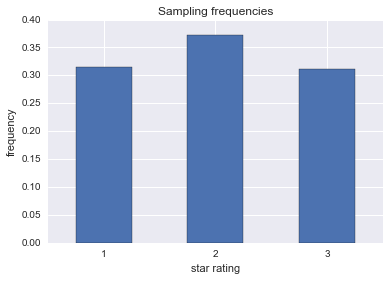

In [254]:
pd.Series(invert_class_dist(normalize_to_dist(star_freqs))).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('frequency')
plt.xlabel('star rating')
plt.title('Sampling frequencies')

2-star and 3-star reviews are being misclassified often. We can resample the and add more to the data set to smooth it out. 

**reasonable parameter range**  : prec_increase 0,.1,...,1.9,2

# Cross validation

In [213]:
scores23 = defaultdict(list)
os_rates = np.arange(0,2,.1)
folds = 3

In [198]:
cv_df = pd.DataFrame(X_train)
cv_df['star_rating'] = np.array(y_train)
kf = KFold(len(cv_df), n_folds=folds,random_state=1)

In [200]:
# scores_sophisticated = defaultdict(list)

In [214]:
for train,test in list(kf):
    cv_df_train = cv_df.iloc[train]
    cv_df_test = cv_df.iloc[test]
    for rate in os_rates:
        #oversample the newly defined cv train set at rate
        os_train = oversample_stars_simple(cv_df_train,[2,3],perc_increase=rate)
        cv_X_train = np.array(os_train.drop('star_rating',axis=1))
        cv_y_train = np.array(os_train['star_rating'])
        #fit and evaluate model at that rate
        mnb_os = MultinomialNB(fit_prior=True).fit(cv_X_train,cv_y_train)
        cv_X_test = np.array(cv_df_test.drop('star_rating',axis=1))
        cv_y_test = np.array(cv_df_test['star_rating'])
        score = mnb_os.score(cv_X_test,cv_y_test)
        print rate, score
        scores23[str(rate)] += [score]


0.0 0.54498714653
0.1 0.545844044559
0.2 0.548414738646
0.3 0.546700942588
0.4 0.546272493573
0.5 0.549271636675
0.6 0.544558697515
0.7 0.550985432734
0.8 0.543273350471
0.9 0.541988003428
1.0 0.539845758355
1.1 0.538988860326
1.2 0.541559554413
1.3 0.535132819195
1.4 0.537703513282
1.5 0.52442159383
1.6 0.530848329049
1.7 0.520994001714
1.8 0.523136246787
1.9 0.51970865467
0.0 0.539219888556
0.1 0.544363480497
0.2 0.543077582512
0.3 0.546078011144
0.4 0.544363480497
0.5 0.546506643806
0.6 0.540934419203
0.7 0.540077153879
0.8 0.536648092585
0.9 0.53321903129
1.0 0.53321903129
1.1 0.524646378054
1.2 0.52378911273
1.3 0.521645949421
1.4 0.519502786112
1.5 0.507501071582
1.6 0.514359194171
1.7 0.506643806258
1.8 0.498499785684
1.9 0.498071153022
0.0 0.52121731676
0.1 0.524646378054
0.2 0.523360480069
0.3 0.52850407201
0.4 0.531933133305
0.5 0.534933561937
0.6 0.538791255894
0.7 0.54264894985
0.8 0.539648521217
0.9 0.532361765967
1.0 0.539648521217
1.1 0.543934847835
1.2 0.53793399057
1.3

In [206]:
import operator
def get_max_rate(score_dict):
    max_dict = {k:sum(v)/len(v) for k,v in scores.items()}
    return max(max_dict.iteritems(), key=operator.itemgetter(1))[0]

In [215]:
get_max_rate(scores23)

'0.7'

In [209]:
with open('scores.pkl', 'wb') as output:
    pickle.dump(scores, output, pickle.HIGHEST_PROTOCOL)

# Add this knowledge to the model

In [210]:
full_os_train = oversample_stars(cv_df,[1,2,3],perc_increase=.7)

In [211]:
full_os_X_train = np.array(full_os_train.drop('star_rating',axis=1))
full_os_y_train = np.array(full_os_train['star_rating'])

In [259]:
mnb = MultinomialNB(fit_prior=True).fit(full_os_X_train,full_os_y_train)
mnb.score(X_test,y_test)

0.55200000000000005

In [256]:
preds = mnb.predict(X_test)

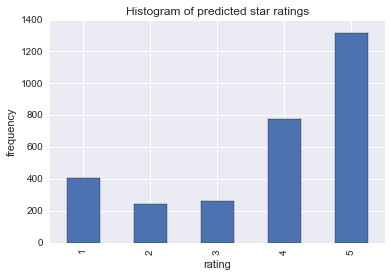

In [257]:
pd.Series(preds).value_counts().sort_index().plot(kind='bar')
plt.ylabel('frequency')
plt.xlabel('rating')
plt.title('Histogram of predicted star ratings')

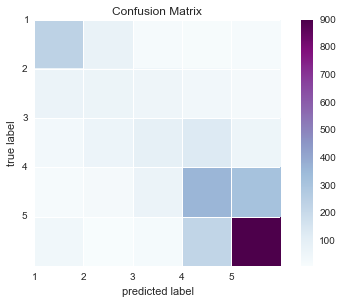

In [258]:
cm = confusion_matrix(y_test,preds,labels=[1,2,3,4,5])


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.colorbar()
plt.xticks(np.arange(-.5,4.5), np.arange(1,6))
plt.yticks(np.arange(-.5,4.5), np.arange(1,6))
plt.tight_layout()
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion Matrix')

# Feature Engineering: clustering

In [39]:
star_counts = dict(df.star_rating.value_counts())
star_word_counts = df.groupby(['star_rating']).sum().T
for k,v in star_counts.items():
    star_word_counts[k] = groups[k]/v

In [40]:
star_word_counts.sort([5],ascending=False).head(30)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


star_rating,1,2,3,4,5
great,0.114424,0.237089,0.353175,0.539394,0.583479
place,0.500403,0.647887,0.584921,0.574242,0.496132
food,0.534247,0.793427,0.680159,0.562121,0.436736
good,0.280419,0.637324,0.867460,0.721970,0.389069
time,0.445608,0.444836,0.367460,0.307197,0.329174
service,0.438356,0.484742,0.353175,0.313258,0.316446
like,0.402901,0.610329,0.541270,0.430682,0.309209
one,0.467365,0.471831,0.383333,0.358333,0.284253
best,0.064464,0.123239,0.134127,0.158712,0.282256
love,0.044319,0.116197,0.114286,0.167045,0.273272


In [106]:
star_word_counts_max = star_word_counts.sort_values(by=[5],ascending=False)
star_word_counts_max['maxes'] = star_word_counts_max.apply(max,axis=1)
frequent_words = star_word_counts_max[star_word_counts_max.maxes >= 0.5]

In [108]:
frequent_words.drop(['maxes'],inplace=True,axis=1)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [109]:
word_sim = np.corrcoef(frequent_words.as_matrix())

In [138]:
spec = SpectralBiclustering(n_clusters=3)

In [139]:
spec.fit(word_sim)

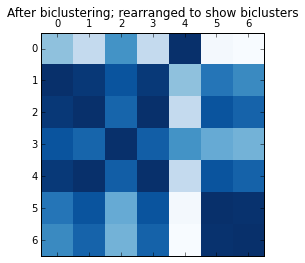

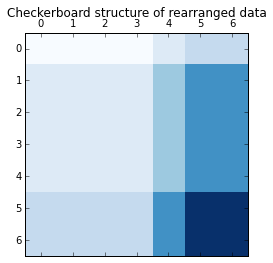

In [140]:
fit_data = word_sim[np.argsort(spec.row_labels_)]
fit_data = fit_data[:, np.argsort(spec.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(np.outer(np.sort(spec.row_labels_) + 1,
                     np.sort(spec.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

plt.show()

### Accuracy Metrics

importnatn to consider what is the best accuracy measure to use to test results. notice that star rating is a ordered 